In [1]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
#import xgboost as xgb
h2o.init(max_mem_size='6G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,15 hours 35 mins
H2O cluster version:,3.12.0.1
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_zhaorc_9ea5bz
H2O cluster total nodes:,1
H2O cluster free memory:,3.944 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


### Import Data & Create Sales Price Dummy Column in Test Dataset

In [29]:
target = h2o.import_file('/Users/zhaorc/Desktop/ML/train_2016_v2.csv')
target.describe()
print('=======================================')
prop=h2o.import_file('/Users/zhaorc/Desktop/ML/properties_2016.csv')
prop.describe()

In [30]:
prop=prop.as_data_frame()
target=target.as_data_frame()

In [32]:
train_df = pd.merge(target, prop, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,1451606400000,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,1451606400000,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,1451606400000,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,1451692800000,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,1451692800000,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [33]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.ix[missing_df['missing_ratio']>0.99]

,column_name,missing_count,missing_ratio
4,architecturalstyletypeid,90014,0.997109
5,basementsqft,90232,0.999524
8,buildingclasstypeid,90259,0.999823
11,decktypeid,89617,0.992711
15,finishedsquarefeet13,90242,0.999634
18,finishedsquarefeet6,89854,0.995336
43,storytypeid,90232,0.999524
45,typeconstructiontypeid,89976,0.996688
48,yardbuildingsqft26,90180,0.998948
51,fireplaceflag,90053,0.997541


#### Dropping the variables that has more than 0.99 missing values.

In [115]:
train_df=train_df.drop(['architecturalstyletypeid','basementsqft','buildingclasstypeid','decktypeid','finishedsquarefeet13','finishedsquarefeet6','storytypeid','typeconstructiontypeid','yardbuildingsqft26','fireplaceflag'],axis=1)

In [116]:
train_df.shape

(90275, 50)

#### Impute Numerical Missing values using GLMR

In [117]:
training_frame = h2o.H2OFrame(train_df)

In [118]:
training_frame.describe()

Rows:90275
Cols:50




,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet15,finishedsquarefeet50,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
type,int,real,int,enum,real,int,int,real,enum,int,int,enum,enum,int,enum,int,enum,enum,enum,int,int,int,real,enum,enum,enum,enum,enum,int,int,enum,real,int,int,enum,int,int,enum,int,enum,int,enum,int,int,int,int,real,enum,enum,int
mins,10711738.0,-4.605,1451606400000.0,,0.0,0.0,1.0,1.0,,2.0,2.0,,,6037.0,,1.0,,,,1.0,33339295.0,-119447865.0,167.0,,,,,,0.0,31.0,,60371011.101000994,3491.0,1286.0,,95982.0,0.0,,1.0,,1885.0,,100.0,22.0,2015.0,22.0,49.08,,,60371011101001.0
mean,12984656.108712278,0.011457219606757104,1465669839260.0396,,2.279473829963995,3.0318692882857894,5.565406875392228,2.309216212272569,,1773.1859865646015,1745.4545305855427,,,6048.870551093883,,2.2412310731482825,,,,3.9269793152639014,34005410.693691485,-118198868.30685116,29110.164176623995,,,,,,202.69972340281996,261.83217945167524,,60491794.81150309,33761.332851071544,2525.4207698698433,,96586.1311835108,1.4785156466352825,,1.1104142032114896,,1968.5328701169587,,180093.39374826188,457672.6273567143,2015.0,278335.3250216009,5983.975926730106,,,60491508546032.766
maxs,162960842.0,4.737,1483056000000.0,,20.0,16.0,12.0,20.0,,22741.0,20013.0,,,6111.0,,20.0,,,,24.0,34816009.0,-117554924.0,6971010.0,,,,,,8800.0,275.0,,61110091.001020014,396556.0,3101.0,,399675.0,18.0,,143.0,,2015.0,,9948100.0,27750000.0,2015.0,24500000.0,321936.09,,,61110091001020.0
sigma,2504510.488301766,0.16107883536718678,7410679638.770855,,1.0042709877071903,1.1564355198675522,1.9006016285969727,0.9761724992343218,,928.1623927208229,909.9411657489284,,,20.663460805186244,,0.9631416217273231,,,,3.684382050531379,264965.3755569022,360603.1997035535,121721.30865440037,,,,,,307.4715268295428,5.182900523458306,,205054.8672682638,46672.393862912155,805.6948419923104,,3661.3390937511494,2.8196270435222077,,0.7972352624935558,,23.76347471454325,,209129.88816860036,554884.3989425425,0.0,400495.4648926158,6838.876956292303,,,204660503527.14096
zeros,0,847,0,,1165,1421,0,0,,0,0,,,0,,0,,,,0,0,0,0,,,,,,1,0,,0,0,0,,0,69700,,0,,0,,0,0,0,0,0,,,0
missing,0,0,0,0,0,0,32911,1182,0,661,4679,0,0,0,0,1182,0,0,0,34195,0,0,10150,0,0,0,0,0,16160,0,0,0,1803,0,0,35,0,0,31922,0,756,0,380,1,0,1,6,0,0,605
0,11016594.0,0.027600000000000006,1451606400000.0,1.0,2.0,3.0,4.0,2.0,nan,1684.0,1684.0,nan,nan,6037.0,nan,2.0,nan,nan,nan,2.0,34280990.0,-118488536.0,7528.0,nan,nan,nan,nan,nan,100.0,261.0,LARS,60371066.461000994,12447.0,3101.0,31817.0,96370.0,0.0,nan,1.0,nan,1959.0,nan,122754.0,360170.0,2015.0,237416.0,6735.88,nan,nan,60371066461001.0
1,14366692.0,-0.16840000000000002,1451606400000.0,nan,3.5,4.0,nan,3.5,nan,2263.0,2263.0,nan,nan,6059.0,nan,3.0,2.0,468.0,nan,nan,33668120.0,-117677556.0,3643.0,nan,nan,nan,nan,nan,1.0,261.0,nan,60590524.222023994,32380.0,1286.0,nan,96962.0,0.0,1.0,nan,nan,2014.0,nan,346458.0,585529.0,2015.0,239071.0,10153.02,nan,nan,nan
2,12098116.0,-0.004,1451606400000.0,1.0,3.0,2.0,4.0,3.0,nan,2217.0,2217.0,nan,nan,6037.0,nan,3.0,nan,nan,nan,2.0,34136312.0,-118175032.0,11423.0,nan,nan,nan,nan,nan,100.0,261.0,PSR6,60374638.003004014,47019.0,3101.0,275411.0,96293.0,0.0,nan,1.0,nan,1940.0,nan,61994.0,119906.0,2015.0,57912.0,11484.48,nan,nan,60374638003004.0


In [119]:
def get_type_lists(frame, rejects=['parcelid', 'logerror','transactiondate']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [120]:
original_nums, cats = get_type_lists(training_frame)

Numeric = ['regionidzip', 'latitude', 'rawcensustractandblock', 'regionidcity', 'propertylandusetypeid', 'taxamount', 'taxvaluedollarcnt', 'roomcnt', 'calculatedfinishedsquarefeet', 'buildingqualitytypeid', 'finishedsquarefeet12', 'bedroomcnt', 'landtaxvaluedollarcnt', 'yearbuilt', 'calculatedbathnbr', 'lotsizesquarefeet', 'assessmentyear', 'propertycountylandusecode', 'unitcnt', 'fips', 'heatingorsystemtypeid', 'fullbathcnt', 'censustractandblock', 'regionidcounty', 'longitude', 'structuretaxvaluedollarcnt', 'bathroomcnt']

Categorical = ['pooltypeid2', 'taxdelinquencyyear', 'poolcnt', 'taxdelinquencyflag', 'propertyzoningdesc', 'fireplacecnt', 'yardbuildingsqft17', 'poolsizesum', 'numberofstories', 'garagetotalsqft', 'airconditioningtypeid', 'pooltypeid7', 'hashottuborspa', 'regionidneighborhood', 'garagecarcnt', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'pooltypeid10', 'threequarterbathnbr', 'finishedsquarefeet15']


In [132]:
train, test = training_frame.split_frame([0.7], seed=12345)
print(train.shape)
print(test.shape)

(63186, 50)
(27089, 50)


In [121]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                    # create 10 features 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05)            # regularization on values in Y

    # train GLRM
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiply the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

train missing:
 [32911.0, 1182.0, 661.0, 4679.0, 1182.0, 34195.0, 10150.0, 16160.0, 1803.0, 35.0, 31922.0, 756.0, 380.0, 1.0, 1.0, 6.0, 605.0]
imputed train missing:
 []


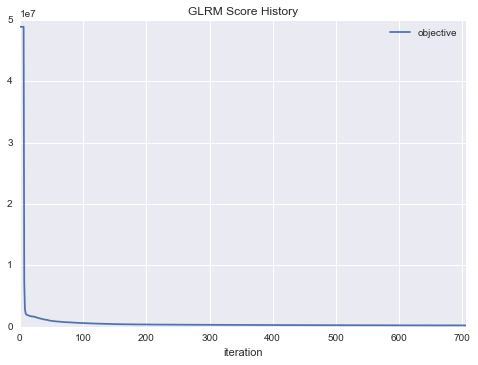

In [122]:
train_new_nums = glrm_num_impute('train', training_frame)

In [133]:
def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        k=50,
        transform='STANDARDIZE',
        loss='Quadratic',
        regularization_x='Quadratic',
        regularization_y='L1',
        gamma_x=0.25,
        gamma_y=0.5)

    # train GLRM
    cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    cat_embed_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # extracted embedded features
    cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    return cat_embed

In [ ]:
train_cat_embed = glrm_cat_embed(training_frame)

In [123]:
from sklearn.preprocessing import Imputer

In [124]:
imputed_embedded_train = training_frame[['parcelid', 'logerror']].cbind(train_new_nums)

In [125]:
imputed_embedded_train.shape #combined inputed and id and target

(90275, 28)

In [126]:
imp = Imputer(missing_values='NaN', strategy='mode', axis=0)

In [128]:
tr=training_frame.as_data_frame(use_pandas=True)

In [131]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


In [129]:
tr['finishedsquarefeet6'].fillna(tr['finishedsquarefeet6'].value_counts().index[0],inplace=True)

KeyError: 'finishedsquarefeet6'

In [101]:
tr['buildingclasstypeid'].fillna(tr['buildingclasstypeid'].value_counts().index[0],inplace=True)
tr['pooltypeid2'].fillna(tr['pooltypeid2'].value_counts().index[0],inplace=True)
tr['taxdelinquencyyear'].fillna(tr['taxdelinquencyyear'].value_counts().index[0],inplace=True)
tr['poolcnt'].fillna(tr['poolcnt'].value_counts().index[0],inplace=True)
tr['basementsqft'].fillna(tr['basementsqft'].value_counts().index[0],inplace=True)
tr['taxdelinquencyflag'].fillna(tr['taxdelinquencyflag'].value_counts().index[0],inplace=True)
tr['fireplacecnt'].fillna(tr['fireplacecnt'].value_counts().index[0],inplace=True)
tr['typeconstructiontypeid'].fillna(tr['typeconstructiontypeid'].value_counts().index[0],inplace=True)
tr['poolsizesum'].fillna(tr['poolsizesum'].value_counts().index[0],inplace=True)
tr['numberofstories'].fillna(tr['numberofstories'].value_counts().index[0],inplace=True)
tr['garagetotalsqft'].fillna(tr['garagetotalsqft'].value_counts().index[0],inplace=True)
tr['yardbuildingsqft26'].fillna(tr['yardbuildingsqft26'].value_counts().index[0],inplace=True)
tr['airconditioningtypeid'].fillna(tr['airconditioningtypeid'].value_counts().index[0],inplace=True)
tr['pooltypeid7'].fillna(tr['pooltypeid7'].value_counts().index[0],inplace=True)
tr['finishedsquarefeet13'].fillna(tr['finishedsquarefeet13'].value_counts().index[0],inplace=True)
tr['hashottuborspa'].fillna(tr['hashottuborspa'].value_counts().index[0],inplace=True)
tr['regionidneighborhood'].fillna(tr['regionidneighborhood'].value_counts().index[0],inplace=True)

In [102]:
tr['architecturalstyletypeid'].fillna(tr['architecturalstyletypeid'].value_counts().index[0],inplace=True)
tr['decktypeid'].fillna(tr['decktypeid'].value_counts().index[0],inplace=True)
tr['garagecarcnt'].fillna(tr['garagecarcnt'].value_counts().index[0],inplace=True)
tr['propertyzoningdesc'].fillna(tr['propertyzoningdesc'].value_counts().index[0],inplace=True)
tr['finishedfloor1squarefeet'].fillna(tr['finishedfloor1squarefeet'].value_counts().index[0],inplace=True)
tr['finishedsquarefeet50'].fillna(tr['finishedsquarefeet50'].value_counts().index[0],inplace=True)
tr['pooltypeid10'].fillna(tr['pooltypeid10'].value_counts().index[0],inplace=True)
tr['threequarterbathnbr'].fillna(tr['threequarterbathnbr'].value_counts().index[0],inplace=True)
tr['fireplaceflag'].fillna(tr['fireplaceflag'].value_counts().index[0],inplace=True)
tr['storytypeid'].fillna(tr['storytypeid'].value_counts().index[0],inplace=True)
tr['finishedsquarefeet15'].fillna(tr['finishedsquarefeet15'].value_counts().index[0],inplace=True)

In [104]:
tr=h2o.H2OFrame(tr)

In [ ]:
# one-hot encode training frame
train_cats_df = train[cats].as_data_frame()
train_cats_df_dummies = pd.get_dummies(train_cats_df)


# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
#valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
#valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)

# one-hot encode test frame
#test_cats_df = test[cats].as_data_frame()
#test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
#train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
#train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
#valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
#print(valid_cats_df_dummies.shape)
#print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
#train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
#test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
#print(valid_cats_df_dummies.shape)
#print(test_cats_df_dummies.shape)
p#rint(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = train.cbind(train_one_hot)

#valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
#valid_one_hot.columns = list(valid_cats_df_dummies.columns)
#valid = valid.cbind(valid_one_hot)

#test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
#test_one_hot.columns = list(test_cats_df_dummies.columns)
#test = test.cbind(test_one_hot)

In [3]:
excludevars = ['ID','SalePrice']
def get_type_lists(frame, rejects=excludevars):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists(trainori)

Numeric = ['OverallCond', 'MasVnrArea', 'OverallQual', 'LotArea', 'FullBath', 'GarageCars', 'Id', 'PoolArea', 'EnclosedPorch', 'WoodDeckSF', 'BedroomAbvGr', '1stFlrSF', 'KitchenAbvGr', 'MiscVal', 'BsmtHalfBath', 'YrSold', 'OpenPorchSF', 'GrLivArea', '3SsnPorch', 'BsmtFinSF1', 'MoSold', 'YearRemodAdd', '2ndFlrSF', 'MSSubClass', 'Fireplaces', 'HalfBath', 'BsmtUnfSF', 'GarageYrBlt', 'ScreenPorch', 'YearBuilt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtFullBath', 'GarageArea', 'LowQualFinSF', 'LotFrontage', 'BsmtFinSF2']

Categorical = ['LandSlope', 'KitchenQual', 'BsmtCond', 'GarageType', 'SaleType', 'Exterior1st', 'Utilities', 'Foundation', 'LotConfig', 'Heating', 'MasVnrType', 'MSZoning', 'BsmtExposure', 'BsmtFinType1', 'SaleCondition', 'PavedDrive', 'Street', 'Exterior2nd', 'PoolQC', 'LotShape', 'ExterQual', 'BsmtFinType2', 'CentralAir', 'HeatingQC', 'Functional', 'GarageQual', 'FireplaceQu', 'GarageFinish', 'LandContour', 'Condition2', 'Neighborhood', 'Condition1', 'Electrical', 'GarageCond

## Preprocessing

In [7]:
pandas_train = train.as_data_frame(use_pandas=True) #Convert to Pandas frame
pandas_test = test.as_data_frame(use_pandas=True) 

In [8]:
# Lotfrontage
temp = pandas_train.groupby('Neighborhood', as_index=False)['LotFrontage'].median()
temp = temp.rename(columns={"LotFrontage":"LotFrontage2"})
pandas_train = pd.merge(pandas_train, temp, how='left', on='Neighborhood')
pandas_train['LotFrontage'][pandas_train['LotFrontage'].isnull()] = pandas_train['LotFrontage2'][pandas_train['LotFrontage'].isnull()]
pandas_train = pandas_train.drop('LotFrontage2', axis=1)


temp = pandas_test.groupby('Neighborhood', as_index=False)['LotFrontage'].median()
temp = temp.rename(columns={"LotFrontage":"LotFrontage2"})
pandas_test = pd.merge(pandas_test, temp, how='left', on='Neighborhood')
pandas_test['LotFrontage'][pandas_test['LotFrontage'].isnull()] = pandas_test['LotFrontage2'][pandas_test['LotFrontage'].isnull()]
pandas_test = pandas_test.drop('LotFrontage2', axis=1)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Alley
pandas_train["Alley"].fillna("None", inplace=True)

pandas_test["Alley"].fillna("None", inplace=True)


In [10]:
# MasVnrType, MasVnrArea
pandas_train['MasVnrType'].fillna(pandas_train['MasVnrType'].value_counts().index[0],inplace=True)
pandas_train['MasVnrArea'].fillna(pandas_train['MasVnrArea'].mode()[0],inplace=True)


pandas_test['MasVnrType'].fillna(pandas_train['MasVnrType'].value_counts().index[0],inplace=True)
pandas_test['MasVnrArea'].fillna(pandas_train['MasVnrArea'].mode()[0],inplace=True)

In [11]:
# Basement related

basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

pandas_train["BsmtQual"].fillna("None", inplace=True)
pandas_train["BsmtCond"].fillna("None", inplace=True)
pandas_train["BsmtExposure"].fillna("None", inplace=True)
pandas_train["BsmtFinType1"].fillna("None", inplace=True)
pandas_train["BsmtFinSF1"].fillna(0, inplace=True)
pandas_train["BsmtFinType2"].fillna("None", inplace=True)
pandas_train["BsmtFinSF2"].fillna(0, inplace=True)
pandas_train["BsmtUnfSF"].fillna(0, inplace=True)

pandas_test["BsmtQual"].fillna("None", inplace=True)
pandas_test["BsmtCond"].fillna("None", inplace=True)
pandas_test["BsmtExposure"].fillna("None", inplace=True)
pandas_test["BsmtFinType1"].fillna("None", inplace=True)
pandas_test["BsmtFinSF1"].fillna(0, inplace=True)
pandas_test["BsmtFinType2"].fillna("None", inplace=True)
pandas_test["BsmtFinSF2"].fillna(0, inplace=True)
pandas_test["BsmtUnfSF"].fillna(0, inplace=True)

In [12]:
pandas_test[basement_cols][pandas_train['BsmtQual'].isnull()==True]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2


In [13]:
# Electrical
pandas_train["Electrical"].fillna("SBrkr", inplace=True)

pandas_test["Electrical"].fillna("SBrkr", inplace=True)

In [14]:
# FireplaceQu
pandas_train["FireplaceQu"].fillna("None", inplace=True)

pandas_test["FireplaceQu"].fillna("None", inplace=True)

In [15]:
# Garage related
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']

pandas_train["GarageType"].fillna("None", inplace=True)
pandas_train["GarageQual"].fillna("None", inplace=True)
pandas_train["GarageCond"].fillna("None", inplace=True)
pandas_train["GarageFinish"].fillna("None", inplace=True)
pandas_train["GarageCars"].fillna(0, inplace=True)
pandas_train["GarageArea"].fillna(0, inplace=True)

pandas_test["GarageType"].fillna("None", inplace=True)
pandas_test["GarageQual"].fillna("None", inplace=True)
pandas_test["GarageCond"].fillna("None", inplace=True)
pandas_test["GarageFinish"].fillna("None", inplace=True)
pandas_test["GarageCars"].fillna(0, inplace=True)
pandas_test["GarageArea"].fillna(0, inplace=True)

In [16]:
# GarageYrBlt Binning

minval = pandas_train['GarageYrBlt'].min()
maxval = pandas_train['GarageYrBlt'].max()+1
binlist=[0,minval,1920,1940,1960,1980,2000,maxval]
pandas_train['GarageYrBlt'].fillna(0,inplace=True)
pandas_train['GarageYrBltBins'] = pd.cut(pandas_train['GarageYrBlt'],binlist,include_lowest=True,right=False)

minval = pandas_test['GarageYrBlt'].min()
maxval = pandas_test['GarageYrBlt'].max()+1
binlist=[0,minval,1920,1940,1960,1980,2000,maxval]
pandas_test['GarageYrBlt'].fillna(0,inplace=True)
pandas_test['GarageYrBltBins'] = pd.cut(pandas_test['GarageYrBlt'],binlist,include_lowest=True,right=False)

In [17]:
# PoolQC
pandas_train["PoolQC"].fillna("None", inplace=True)

pandas_test["PoolQC"].fillna("None", inplace=True)

In [18]:
# Fence, MiscFeature

pandas_train["Fence"].fillna("None", inplace=True)
pandas_train["MiscFeature"].fillna("None", inplace=True)

pandas_test["Fence"].fillna("None", inplace=True)
pandas_test["MiscFeature"].fillna("None", inplace=True)

In [19]:
def show_missing(pandas_frame):
    missing = pandas_frame.columns[pandas_frame.isnull().any()].tolist()
    return missing

In [20]:
show_missing(pandas_train)

[]

In [21]:
show_missing(pandas_test) # 나중에 처리해야..

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'SaleType']

In [22]:
train_h2o = h2o.H2OFrame(pandas_train) #Convert back to H2O frame 
test_h2o = h2o.H2OFrame(pandas_test)

### Set categorical vars

In [23]:
train_h2o['MSSubClass'] = train_h2o['MSSubClass'].asfactor()
train_h2o['OverallQual'] = train_h2o['OverallQual'].asfactor()
train_h2o['OverallCond'] = train_h2o['OverallCond'].asfactor()
train_h2o['YearBuilt'] = train_h2o['YearBuilt'].asfactor()
train_h2o['YearRemodAdd'] = train_h2o['YearRemodAdd'].asfactor()
#train_h2o['GarageYrBlt'] = train_h2o['GarageYrBlt'].asfactor()
train_h2o['MoSold'] = train_h2o['MoSold'].asfactor()
train_h2o['YrSold'] = train_h2o['YrSold'].asfactor()

test_h2o['MSSubClass'] = test_h2o['MSSubClass'].asfactor()
test_h2o['OverallQual'] = test_h2o['OverallQual'].asfactor()
test_h2o['OverallCond'] = test_h2o['OverallCond'].asfactor()
test_h2o['YearBuilt'] = test_h2o['YearBuilt'].asfactor()
test_h2o['YearRemodAdd'] = test_h2o['YearRemodAdd'].asfactor()
#test_h2o['GarageYrBlt'] = test_h2o['GarageYrBlt'].asfactor()
test_h2o['MoSold'] = test_h2o['MoSold'].asfactor()
test_h2o['YrSold'] = test_h2o['YrSold'].asfactor()

In [24]:
excludevars = ['Id','SalePrice', 'GarageYrBltBins2','GarageYrBlt']
nums_afterpp, cats_afterpp = get_type_lists(train_h2o, excludevars)

Numeric = ['MasVnrArea', 'LotArea', 'FullBath', 'GarageCars', 'PoolArea', 'EnclosedPorch', 'WoodDeckSF', 'BedroomAbvGr', '1stFlrSF', 'KitchenAbvGr', 'MiscVal', 'BsmtHalfBath', 'OpenPorchSF', 'GrLivArea', '3SsnPorch', 'BsmtFinSF1', '2ndFlrSF', 'Fireplaces', 'HalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtFullBath', 'GarageArea', 'LowQualFinSF', 'LotFrontage', 'BsmtFinSF2', 'ScreenPorch']

Categorical = ['OverallCond', 'LandSlope', 'KitchenQual', 'BsmtCond', 'OverallQual', 'GarageType', 'SaleType', 'Exterior1st', 'Utilities', 'Foundation', 'LotConfig', 'Heating', 'MasVnrType', 'MSZoning', 'BsmtExposure', 'BsmtFinType1', 'SaleCondition', 'YrSold', 'MoSold', 'YearRemodAdd', 'PavedDrive', 'MSSubClass', 'Street', 'Exterior2nd', 'PoolQC', 'LotShape', 'ExterQual', 'BsmtFinType2', 'CentralAir', 'HeatingQC', 'Functional', 'GarageQual', 'GarageYrBltBins', 'FireplaceQu', 'GarageFinish', 'YearBuilt', 'LandContour', 'Condition2', 'Neighborhood', 'Condition1', 'Electrical', 'GarageCond',

In [25]:
train, valid = train_h2o.split_frame([0.7], seed=12345)
test = test_h2o
print(train.shape)
print(valid.shape)

(1001, 82)
(459, 82)


In [26]:
train.describe()

Rows:1001
Cols:82




,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBltBins
type,int,enum,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,int,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,enum,enum,enum,enum,int,enum
mins,1.0,,,21.0,1300.0,,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,480.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,,3.0,,0.0,,,0.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,,,,,34900.0,
mean,724.8291708291705,,,70.74475524475535,10628.262737262736,,,,,,,,,,,,,,,,,,,,,,106.16383616383624,,,,,,,,445.5994005994004,,41.64935064935064,575.9900099900102,1063.2387612387604,,,,,1172.088911088912,341.78721278721247,5.9250749250749255,1519.8011988011988,0.4265734265734266,0.05994005994005996,1.5744255744255726,0.381618381618382,2.8711288711288696,1.0469530469530457,,6.512487512487514,,0.6203796203796214,,,1883.850149850151,,1.7932067932067925,477.4685314685315,,,,91.07392607392609,44.92407592407593,21.257742257742255,3.4565434565434567,14.763236763236765,3.376623376623376,,,,39.684315684315685,,,,,182171.95904095893,
maxs,1460.0,,,313.0,164660.0,,,,,,,,,,,,,,,,,,,,,,1378.0,,,,,,,,5644.0,,1127.0,2153.0,6110.0,,,,,4692.0,2065.0,528.0,5642.0,3.0,2.0,3.0,2.0,8.0,3.0,,14.0,,3.0,,,2010.0,,4.0,1418.0,,,,736.0,523.0,552.0,508.0,440.0,738.0,,,,15500.0,,,,,755000.0,
sigma,421.4954943866087,,,23.15278676455676,9442.37310711137,,,,,,,,,,,,,,,,,,,,,,179.66239765423683,,,,,,,,467.17326588712297,,148.91838678308972,444.45750741786287,450.4683539784607,,,,,392.4739572085174,432.9085950594231,49.51948485817861,520.2774292995629,0.5204355357324734,0.2457714312193271,0.5538098001166959,0.5002217290580031,0.8052177496650357,0.22537348289718281,,1.587480364002624,,0.6416730131026673,,,423.68187301615546,,0.7349787794173421,209.92257920181268,,,,120.05044160464608,63.01874506660877,61.04442237008644,29.83605804459362,54.16981527671003,43.98791894358055,,,,516.2493547150991,,,,,80367.94618029826,
zeros,0,,,0,0,,,,,,,,,,,,,,,,,,,,,,577,,,,,,,,326,,894,78,25,,,,,0,572,984,0,586,943,6,626,4,1,,0,,466,,,48,,48,48,,,,523,460,867,985,921,995,,,,969,,,,,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,60,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal,208500.0,"[2000, 2011)"
1,2.0,20,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298

In [27]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


In [28]:
total = len(cats_afterpp)
for i, var in enumerate(cats_afterpp):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: OverallCond (1/51) ...
Encoding: LandSlope (2/51) ...
Encoding: KitchenQual (3/51) ...
Encoding: BsmtCond (4/51) ...
Encoding: OverallQual (5/51) ...
Encoding: GarageType (6/51) ...
Encoding: SaleType (7/51) ...
Encoding: Exterior1st (8/51) ...
Encoding: Utilities (9/51) ...
Encoding: Foundation (10/51) ...
Encoding: LotConfig (11/51) ...
Encoding: Heating (12/51) ...
Encoding: MasVnrType (13/51) ...
Encoding: MSZoning (14/51) ...
Encoding: BsmtExposure (15/51) ...
Encoding: BsmtFinType1 (16/51) ...
Encoding: SaleCondition (17/51) ...
Encoding: YrSold (18/51) ...
Encoding: MoSold (19/51) ...
Encoding: YearRemodAdd (20/51) ...
Encoding: PavedDrive (21/51) ...
Encoding: MSSubClass (22/51) ...
Encoding: Street (23/51) ...
Encoding: Exterior2nd (24/51) ...
Encoding: PoolQC (25/51) ...
Encoding: LotShape (26/51) ...
Encoding: ExterQual (27/51) ...
Encoding: BsmtFinType2 (28/51) ...
Encoding: CentralAir (29/51) ...
Encoding: HeatingQC (30/51) ...
Encoding: Functional (31/51) ...
En

In [29]:
train.describe()

Rows:1001
Cols:133




,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GarageYrBltBins,OverallCond_Tencode,LandSlope_Tencode,KitchenQual_Tencode,BsmtCond_Tencode,OverallQual_Tencode,GarageType_Tencode,SaleType_Tencode,Exterior1st_Tencode,Utilities_Tencode,Foundation_Tencode,LotConfig_Tencode,Heating_Tencode,MasVnrType_Tencode,MSZoning_Tencode,BsmtExposure_Tencode,BsmtFinType1_Tencode,SaleCondition_Tencode,YrSold_Tencode,MoSold_Tencode,YearRemodAdd_Tencode,PavedDrive_Tencode,MSSubClass_Tencode,Street_Tencode,Exterior2nd_Tencode,PoolQC_Tencode,LotShape_Tencode,ExterQual_Tencode,BsmtFinType2_Tencode,CentralAir_Tencode,HeatingQC_Tencode,Functional_Tencode,GarageQual_Tencode,GarageYrBltBins_Tencode,FireplaceQu_Tencode,GarageFinish_Tencode,YearBuilt_Tencode,LandContour_Tencode,Condition2_Tencode,Neighborhood_Tencode,Condition1_Tencode,Electrical_Tencode,GarageCond_Tencode,BldgType_Tencode,Fence_Tencode,Alley_Tencode,RoofMatl_Tencode,ExterCond_Tencode,MiscFeature_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,HouseStyle_Tencode
type,int,enum,enum,real,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,enum,int,enum,int,enum,enum,int,enum,int,int,enum,enum,enum,int,int,int,int,int,int,enum,enum,enum,int,enum,enum,enum,enum,int,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1.0,,,21.0,1300.0,,,,,,,,,,,,,,,,,,,,,,0.0,,,,,,,,0.0,,0.0,0.0,0.0,,,,,480.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,,3.0,,0.0,,,0.0,,0.0,0.0,,,,0.0,0.0,0.0,0.0,0.0,0.0,,,,0.0,,,,,34900.0,,116283.85154845155,181486.5182747485,124936.94820396995,84275.79385614385,57340.143856143855,119405.5855228105,125968.29385614385,78325.79385614385,144200.79385614386,121726.89385614387,176473.2899159664,93469.96052281052,156555.86183074262,78614.79385614385,123956.21308691308,121276.42985614385,115832.04385614385,179239.41089108912,171267.6210300569,104035.31885614386,129253.89464979463,110931.40933233431,146350.10385614386,129978.23968947721,181425.2874371859,163944.59385614382,116078.96885614384,126947.55924075923,119608.23368665231,135668.69902855766,110059.12718947718,96813.29385614385,119405.5855228105,141462.34885614386,119405.5855228105,103613.29385614385,145140.16285614387,108075.79385614385,109690.79385614385,134468.29385614386,84275.79385614385,112070.79385614385,138273.46052281052,141306.73814185814,128075.200999001,143775.79385614386,122047.14941169939,140375.79385614386,161577.2224275724,121216.12093947716,118907.22242757239
mean,724.8291708291705,,,70.74475524475535,10628.262737262736,,,,,,,,,,,,,,,,,,,,,,106.16383616383624,,,,,,,,445.5994005994004,,41.64935064935064,575.9900099900102,1063.2387612387604,,,,,1172.088911088912,341.78721278721247,5.9250749250749255,1519.8011988011988,0.4265734265734266,0.05994005994005996,1.5744255744255726,0.381618381618382,2.8711288711288696,1.0469530469530457,,6.512487512487514,,0

In [30]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['MasVnrArea', 'YrSold_Tencode', 'LotArea', 'GarageYrBlt', 'GarageCars', 'BsmtFullBath', 'OpenPorchSF', 'PoolArea', 'CentralAir_Tencode', 'Street_Tencode', 'PavedDrive_Tencode', 'KitchenAbvGr', 'LandContour_Tencode', 'ScreenPorch', 'BsmtHalfBath', 'Fence_Tencode', 'MSZoning_Tencode', '3SsnPorch', 'MSSubClass_Tencode', 'ExterQual_Tencode', '2ndFlrSF', 'Exterior1st_Tencode', 'BldgType_Tencode', 'Condition1_Tencode', 'BsmtUnfSF', 'Condition2_Tencode', 'GarageCond_Tencode', 'OverallCond_Tencode', 'OverallQual_Tencode', 'FireplaceQu_Tencode', 'GarageFinish_Tencode', 'BsmtCond_Tencode', 'SaleCondition_Tencode', 'TotalBsmtSF', 'GarageArea', 'BsmtFinType2_Tencode', 'LowQualFinSF', 'Heating_Tencode', 'Foundation_Tencode', 'HeatingQC_Tencode', 'FullBath', 'Id', 'Utilities_Tencode', 'EnclosedPorch', 'BsmtFinType1_Tencode', 'WoodDeckSF', 'BedroomAbvGr', 'SaleType_Tencode', '1stFlrSF', 'MoSold_Tencode', 'GarageQual_Tencode', 'LotShape_Tencode', 'RoofStyle_Tencode', 'BsmtQual_Tencode', 'Mi

In [33]:
len(encoded_nums)

81

In [34]:
print(train.shape)

(1001, 133)


In [35]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:81




,MasVnrArea,YrSold_Tencode,LotArea,GarageYrBlt,GarageCars,BsmtFullBath,OpenPorchSF,PoolArea,CentralAir_Tencode,Street_Tencode,PavedDrive_Tencode,KitchenAbvGr,LandContour_Tencode,ScreenPorch,BsmtHalfBath,Fence_Tencode,MSZoning_Tencode,3SsnPorch,MSSubClass_Tencode,ExterQual_Tencode,2ndFlrSF,Exterior1st_Tencode,BldgType_Tencode,Condition1_Tencode,BsmtUnfSF,Condition2_Tencode,GarageCond_Tencode,OverallCond_Tencode,OverallQual_Tencode,FireplaceQu_Tencode,GarageFinish_Tencode,BsmtCond_Tencode,SaleCondition_Tencode,TotalBsmtSF,GarageArea,BsmtFinType2_Tencode,LowQualFinSF,Heating_Tencode,Foundation_Tencode,HeatingQC_Tencode,FullBath,Id,Utilities_Tencode,EnclosedPorch,BsmtFinType1_Tencode,WoodDeckSF,BedroomAbvGr,SaleType_Tencode,1stFlrSF,MoSold_Tencode,GarageQual_Tencode,LotShape_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,MiscFeature_Tencode,GrLivArea,ExterCond_Tencode,BsmtFinSF1,LandSlope_Tencode,Neighborhood_Tencode,Fireplaces,Electrical_Tencode,HalfBath,Alley_Tencode,LotConfig_Tencode,KitchenQual_Tencode,YearRemodAdd_Tencode,MasVnrType_Tencode,GarageType_Tencode,LotFrontage,HouseStyle_Tencode,GarageYrBltBins_Tencode,Exterior2nd_Tencode,TotRmsAbvGrd,RoofMatl_Tencode,BsmtExposure_Tencode,MiscVal,YearBuilt_Tencode,PoolQC_Tencode,BsmtFinSF2,Functional_Tencode
type,int,real,int,int,int,int,int,int,real,real,real,int,real,int,int,real,real,int,real,real,int,real,real,real,int,real,real,real,real,real,real,real,real,int,int,real,int,real,real,real,int,int,real,int,real,int,int,real,int,real,real,real,real,real,real,int,real,int,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,int,real,real,int,real,real,int,real
mins,0.0,179239.41089108912,1300.0,0.0,0.0,0.0,0.0,0.0,119608.23368665231,146350.10385614386,129253.89464979463,0.0,145140.16285614387,0.0,0.0,141306.73814185814,78614.79385614385,0.0,110931.40933233431,116078.96885614384,0.0,78325.79385614385,138273.46052281052,134468.29385614386,0.0,108075.79385614385,112070.79385614385,116283.85154845155,57340.143856143855,141462.34885614386,119405.5855228105,84275.79385614385,115832.04385614385,0.0,0.0,126947.55924075923,0.0,93469.96052281052,121726.89385614387,135668.69902855766,0.0,1.0,144200.79385614386,0.0,121276.42985614385,0.0,0.0,125968.29385614385,480.0,171267.6210300569,96813.29385614385,163944.59385614382,161577.2224275724,121216.12093947716,140375.79385614386,480.0,122047.14941169939,0.0,181486.5182747485,109690.79385614385,0.0,84275.79385614385,0.0,128075.200999001,176473.2899159664,124936.94820396995,104035.31885614386,156555.86183074262,119405.5855228105,21.0,118907.22242757239,119405.5855228105,129978.23968947721,3.0,143775.79385614386,123956.21308691308,0.0,103613.29385614385,181425.2874371859,0.0,110059.12718947718
mean,106.16383616383624,182185.62702342597,10628.262737262736,1883.850149850151,1.7932067932067925,0.4265734265734266,44.92407592407593,3.376623376623376,182822.70708043195,182203.5349842965,182908.1805595005,1.0469530469530457,182186.7329973223,14.763236763236765,0.05994005994005996,183005.0923464647,183387.92640181998,3.4565434565434567,184318.41699728824,181095.696027499,341.78721278721247,183565.71379414786,182849.79797599994,182645.11776425384,575.9900099900102,182224.44204037718,182992.97056335275,183250.586628257,180290.10698776753,181849.37466200133,182703.09600908577,182522.25164540764,181541.3249445857,1063.2387612387604,477.4685314685315,182622.35788112954,5.9250749250749255,182323.57985955084,183119.90242260238,182409.70856326495,1.5744255744255726,724.8291708291705,182178.6531407155,21.257742257742255,184124.927790092,91.07392607392609,2.8711288711288696,181180.3311701287,1172.088911088912,182085.76055692547,183008.55356277092,181993.92786324595,182159.00869385348,180724.5454251543,182343.8002408678,1519.8011988011988,182637.23505924654,445.5994005994004,182145.0556687068,182171.95904095893,0.6203796203796214,182937.98398065448,0.381618381618382,182525.0014360763,181772.16118142588,180810.9702399497,182171.95904095907,180953.69104

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:81




,MasVnrArea,YrSold_Tencode,LotArea,GarageYrBlt,GarageCars,BsmtFullBath,OpenPorchSF,PoolArea,CentralAir_Tencode,Street_Tencode,PavedDrive_Tencode,KitchenAbvGr,LandContour_Tencode,ScreenPorch,BsmtHalfBath,Fence_Tencode,MSZoning_Tencode,3SsnPorch,MSSubClass_Tencode,ExterQual_Tencode,2ndFlrSF,Exterior1st_Tencode,BldgType_Tencode,Condition1_Tencode,BsmtUnfSF,Condition2_Tencode,GarageCond_Tencode,OverallCond_Tencode,OverallQual_Tencode,FireplaceQu_Tencode,GarageFinish_Tencode,BsmtCond_Tencode,SaleCondition_Tencode,TotalBsmtSF,GarageArea,BsmtFinType2_Tencode,LowQualFinSF,Heating_Tencode,Foundation_Tencode,HeatingQC_Tencode,FullBath,Id,Utilities_Tencode,EnclosedPorch,BsmtFinType1_Tencode,WoodDeckSF,BedroomAbvGr,SaleType_Tencode,1stFlrSF,MoSold_Tencode,GarageQual_Tencode,LotShape_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,MiscFeature_Tencode,GrLivArea,ExterCond_Tencode,BsmtFinSF1,LandSlope_Tencode,Neighborhood_Tencode,Fireplaces,Electrical_Tencode,HalfBath,Alley_Tencode,LotConfig_Tencode,KitchenQual_Tencode,YearRemodAdd_Tencode,MasVnrType_Tencode,GarageType_Tencode,LotFrontage,HouseStyle_Tencode,GarageYrBltBins_Tencode,Exterior2nd_Tencode,TotRmsAbvGrd,RoofMatl_Tencode,BsmtExposure_Tencode,MiscVal,YearBuilt_Tencode,PoolQC_Tencode,BsmtFinSF2,Functional_Tencode
type,int,real,int,int,int,int,int,int,real,real,real,int,real,int,int,real,real,int,real,real,int,real,real,real,int,real,real,real,real,real,real,real,real,int,int,real,int,real,real,real,int,int,real,int,real,int,int,real,int,real,real,real,real,real,real,int,real,int,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,int,real,real,int,real,real,int,real
mins,0.0,169627.25564187934,1491.0,0.0,0.0,0.0,0.0,0.0,111601.52450980392,95579.02450980392,114840.96895424835,1.0,163075.56297134238,0.0,0.0,133419.96200980392,118217.35784313723,0.0,95012.35784313723,91042.14950980392,0.0,96429.02450980392,128987.56617647059,150223.0311764706,0.0,84954.02450980392,108352.20632798571,78579.02450980392,69356.52450980392,133191.52450980392,108352.20632798571,78579.02450980392,143816.52450980392,0.0,0.0,107897.15367647057,0.0,77729.02450980392,110363.31736694675,100679.02450980392,0.0,4.0,178193.4967320261,0.0,107897.15367647057,0.0,0.0,107734.02450980392,334.0,162484.5985098039,108352.20632798571,163981.4191419142,139864.02450980392,107897.15367647057,73479.02450980392,334.0,91754.02450980392,0.0,175531.83179723503,112866.7168174962,0.0,100143.52450980392,0.0,134607.54723707662,165751.57330498463,105130.89950980392,120621.97532947603,131576.52450980392,108352.20632798571,21.0,122402.59593837534,108352.20632798571,106204.02450980392,2.0,175904.02450980392,107897.15367647057,0.0,79514.02450980392,178187.36899563318,0.0,84954.02450980392
mean,96.47276688453148,178193.496732026,10273.808278867102,1835.7864923747268,1.7102396514161213,0.42265795206971674,50.44662309368192,1.411764705882353,179115.18492887347,178225.25931265744,179002.96058140023,1.0457516339869268,177854.22806185653,15.710239651416122,0.05228758169934641,178943.90578410032,179328.32668845326,3.30718954248366,178290.67043872018,174940.29949164853,358.34422657952064,179651.10523303007,178649.14910504507,178617.62590029478,548.159041394335,178197.18104147993,179410.743410654,180314.7703639625,178193.49673202616,175300.38912811334,176100.76506899047,178575.42264940837,177335.48292323473,1044.760348583878,463.19172113289744,178749.88685121093,5.668845315904139,178371.04867785898,179041.90369302416,180663.66151693798,1.544662309368193,742.8671023965148,178193.4967320261,23.4727668845316,178193.49673202584,101.15904139433547,2.856209150326796,177239.63702422142,1141.9912854030508,178193.49673202605,179173.93458285267,176786.22238241715,177381.14581571185,177231.78653936516,178331.82024007873,1506.0043572984757,178484.55631381104,439.36601307189557,177815.9926203596,178193.49673202608,0.5969498910675383,179083.62772865142,0.3856209150326796,178551.46728608664,178163.2663740442,177298.28443120178,178193.49673202634,176236.

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:81




,MasVnrArea,YrSold_Tencode,LotArea,GarageYrBlt,GarageCars,BsmtFullBath,OpenPorchSF,PoolArea,CentralAir_Tencode,Street_Tencode,PavedDrive_Tencode,KitchenAbvGr,LandContour_Tencode,ScreenPorch,BsmtHalfBath,Fence_Tencode,MSZoning_Tencode,3SsnPorch,MSSubClass_Tencode,ExterQual_Tencode,2ndFlrSF,Exterior1st_Tencode,BldgType_Tencode,Condition1_Tencode,BsmtUnfSF,Condition2_Tencode,GarageCond_Tencode,OverallCond_Tencode,OverallQual_Tencode,FireplaceQu_Tencode,GarageFinish_Tencode,BsmtCond_Tencode,SaleCondition_Tencode,TotalBsmtSF,GarageArea,BsmtFinType2_Tencode,LowQualFinSF,Heating_Tencode,Foundation_Tencode,HeatingQC_Tencode,FullBath,Id,Utilities_Tencode,EnclosedPorch,BsmtFinType1_Tencode,WoodDeckSF,BedroomAbvGr,SaleType_Tencode,1stFlrSF,MoSold_Tencode,GarageQual_Tencode,LotShape_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,MiscFeature_Tencode,GrLivArea,ExterCond_Tencode,BsmtFinSF1,LandSlope_Tencode,Neighborhood_Tencode,Fireplaces,Electrical_Tencode,HalfBath,Alley_Tencode,LotConfig_Tencode,KitchenQual_Tencode,YearRemodAdd_Tencode,MasVnrType_Tencode,GarageType_Tencode,LotFrontage,HouseStyle_Tencode,GarageYrBltBins_Tencode,Exterior2nd_Tencode,TotRmsAbvGrd,RoofMatl_Tencode,BsmtExposure_Tencode,MiscVal,YearBuilt_Tencode,PoolQC_Tencode,BsmtFinSF2,Functional_Tencode
type,int,real,int,int,int,int,int,int,real,real,real,int,real,int,int,real,real,int,real,real,int,real,real,real,int,real,real,real,real,real,real,real,real,int,int,real,int,real,real,real,int,int,real,int,real,int,int,real,int,real,real,real,real,real,real,int,real,int,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,int,real,real,int,real,real,int,real
mins,0.0,169627.25564187934,1470.0,0.0,0.0,0.0,0.0,0.0,111601.52450980392,95579.02450980392,114840.96895424835,0.0,163075.56297134238,0.0,0.0,133419.96200980392,118217.35784313723,0.0,95012.35784313723,91042.14950980392,0.0,96429.02450980392,128987.56617647059,150223.0311764706,0.0,127029.02450980392,108352.20632798571,78579.02450980392,69356.52450980392,133191.52450980392,108352.20632798571,78579.02450980392,143816.52450980392,0.0,0.0,107897.15367647057,0.0,77729.02450980392,110363.31736694675,100679.02450980392,0.0,1461.0,178193.4967320261,0.0,107897.15367647057,0.0,0.0,107734.02450980392,407.0,162484.5985098039,108352.20632798571,163981.4191419142,139864.02450980392,107897.15367647057,73479.02450980392,407.0,91754.02450980392,0.0,175531.83179723503,112866.7168174962,0.0,100143.52450980392,0.0,134607.54723707662,165751.57330498463,105130.89950980392,120621.97532947603,131576.52450980392,108352.20632798571,21.0,122402.59593837534,139136.05102495544,106204.02450980392,3.0,175904.02450980392,107897.15367647057,0.0,79514.02450980392,178187.36899563318,0.0,84954.02450980392
mean,99.67374914324867,178138.41592993547,9819.161069225516,1871.9897189856056,1.7649074708704602,0.4344543582704184,48.31391363947919,1.7443454420836189,179789.60281035848,178065.0926703297,177090.1544055946,1.0424948594928027,179174.2263375262,17.064427690198773,0.0652024708304736,179260.15082329372,179232.0904301915,1.794379712131597,177704.83404990312,177673.68837649445,325.9677861549004,179810.686881209,178370.3696551594,179939.77372747503,553.9150102810141,178369.39980873468,180887.13312920654,181638.3138716565,181143.66379652923,174678.31798555847,177253.37457383898,177115.4641081019,176492.09637795304,1046.1179698216752,472.4448252227548,178665.96855634326,3.543522960932145,179140.34833949347,181006.29018575946,182227.81273899996,1.570938999314599,2190.0,178193.4967320261,24.243317340644285,180068.38187120648,93.17477724468819,2.8540095956134333,175933.1071534588,1156.5346127484572,178570.99134392996,178833.85891178728,176844.08363718318,177370.70371664243,178942.1349335839,178536.70969509304,1486.0459218642889,178138.292477274,438.9026730637427,177395.21920765375,179660.9318538107,0.5812200137080195,180126.11931528134,0.3776559287183003,178550.03252320114,178278.00897433673,179340.39624644505,176730.68322763144,178146.24432411807,18

In [35]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'ClearCr': 207949.02450980392, 'NridgHt': 284073.1545098039, 'Veenker': 243734.02450980392, 'Gilbert': 191808.0596949891, 'CollgCr': 190019.77971813726, 'MeadowV': 113131.52450980392, 'SWISU': 156269.02450980392, 'NAmes': 152080.32258672698, 'Edwards': 126241.13989441929, 'OldTown': 139863.03613771088, 'BrkSide': 129965.77450980392, 'Blmngtn': 210845.6545098039, 'SawyerW': 189097.7776348039, 'Timber': 260109.74673202613, 'NoRidge': 273948.2552790347, 'Mitchel': 169316.52450980392, 'IDOTRR': 112866.71681749621, 'BrDale': 116064.02450980392, 'NPkVill': 147641.52450980392, 'NWAmes': 184610.14950980392, 'StoneBr': 288359.0245098039, 'Sawyer': 143162.40700980392, 'Crawfor': 216008.84593837534, 'Somerst': 227656.9671023965}


In [36]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [37]:
len(encoded_nums)

81

In [38]:
train.shape

(1001, 133)

In [39]:
train2, _ = feature_combiner(train, test, encoded_nums)
valid2, test2 = feature_combiner(valid, test, encoded_nums)

Combining: MasVnrArea (1/81) ...
Combining: YrSold_Tencode (2/81) ...
Combining: LotArea (3/81) ...
Combining: GarageYrBlt (4/81) ...
Combining: GarageCars (5/81) ...
Combining: BsmtFullBath (6/81) ...
Combining: OpenPorchSF (7/81) ...
Combining: PoolArea (8/81) ...
Combining: CentralAir_Tencode (9/81) ...
Combining: Street_Tencode (10/81) ...
Combining: PavedDrive_Tencode (11/81) ...
Combining: KitchenAbvGr (12/81) ...
Combining: LandContour_Tencode (13/81) ...
Combining: ScreenPorch (14/81) ...
Combining: BsmtHalfBath (15/81) ...
Combining: Fence_Tencode (16/81) ...
Combining: MSZoning_Tencode (17/81) ...
Combining: 3SsnPorch (18/81) ...
Combining: MSSubClass_Tencode (19/81) ...
Combining: ExterQual_Tencode (20/81) ...
Combining: 2ndFlrSF (21/81) ...
Combining: Exterior1st_Tencode (22/81) ...
Combining: BldgType_Tencode (23/81) ...
Combining: Condition1_Tencode (24/81) ...
Combining: BsmtUnfSF (25/81) ...
Combining: Condition2_Tencode (26/81) ...
Combining: GarageCond_Tencode (27/81)

In [ ]:
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [40]:
encoded_combined_nums, cats = get_type_lists(frame=train2)

Numeric = ['MiscFeature_Tencode|HouseStyle_Tencode', 'Heating_Tencode|Alley_Tencode', 'BsmtFinSF1|LotFrontage', 'YrSold_Tencode|CentralAir_Tencode', 'Exterior1st_Tencode|Alley_Tencode', 'YrSold_Tencode|ScreenPorch', 'EnclosedPorch|MoSold_Tencode', 'ScreenPorch|LowQualFinSF', 'Foundation_Tencode|FullBath', 'FireplaceQu_Tencode|YearRemodAdd_Tencode', 'HeatingQC_Tencode|MiscFeature_Tencode', 'Exterior2nd_Tencode|TotRmsAbvGrd', 'OpenPorchSF|SaleCondition_Tencode', 'PoolArea|Street_Tencode', 'YrSold_Tencode|KitchenQual_Tencode', 'BsmtCond_Tencode|HouseStyle_Tencode', 'Utilities_Tencode|RoofStyle_Tencode', 'BsmtFullBath|GarageCond_Tencode', 'OverallCond_Tencode|Exterior2nd_Tencode', 'LandContour_Tencode|2ndFlrSF', 'GarageArea|LandSlope_Tencode', 'BsmtFinType2_Tencode|LotShape_Tencode', 'OverallCond_Tencode|Utilities_Tencode', 'BsmtCond_Tencode|Electrical_Tencode', 'BsmtFullBath|FullBath', 'Fence_Tencode|1stFlrSF', 'BldgType_Tencode|Electrical_Tencode', 'PoolArea|GarageArea', 'KitchenAbvGr|Be



Categorical = ['Heating', 'BsmtFinType1', 'Condition2', 'ExterQual', 'Functional', 'HouseStyle', 'MasVnrType', 'LotShape', 'Utilities', 'BsmtExposure', 'MiscFeature', 'Foundation', 'Street', 'PoolQC', 'FireplaceQu', 'LandContour', 'KitchenQual', 'SaleCondition', 'BsmtCond', 'GarageCond', 'ExterCond', 'RoofMatl', 'CentralAir', 'LandSlope', 'GarageFinish', 'BsmtFinType2', 'Electrical', 'Fence', 'SaleType', 'Exterior2nd', 'RoofStyle', 'GarageType', 'BsmtQual', 'PavedDrive', 'MSZoning', 'Neighborhood', 'Condition1', 'Exterior1st', 'LotConfig', 'Alley', 'BldgType', 'HeatingQC', 'GarageQual', 'GarageYrBltBins']


In [41]:
train2.shape

(1001, 3373)

In [42]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (1001, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

False
(1001, 133)
False
(1459, 133)


In [43]:
train=train2
valid=valid2
test=test2

In [44]:
h2o.show_progress() # turn on progress bars

SalePrice
12.2477
12.109
12.3172


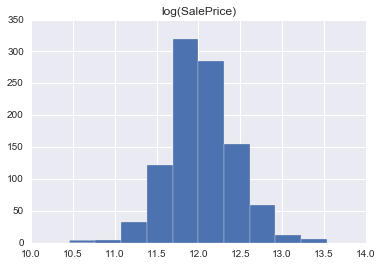

In [45]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

In [64]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

ImportError: cannot import name '_safe_split'

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(encoded_combined_nums, y)

In [45]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               

In [46]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 3373)
(230, 3373)
(497, 3373)
(229, 3373)


In [49]:
import re
import time

def gen_submission(preds, test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

In [48]:
import re
import time

def gen_submission_glm(model, test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


In [56]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

In [50]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                       model_ids  \
0    [0.25]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_1   
1     [0.5]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_2   
2    [0.99]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_3   
3    [0.01]  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_0   

    residual_deviance  
0  3.4056149704726546  
1  3.4432799816367816  
2  3.4997037522117393  
3  3.7551576194833487  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_340_sid_88a6_model_python_1498680313620_15_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013012961718910504
RMSE: 0.11407436924616547
MAE: 0.0804187668027057
RMSLE: 0.00892713691702441
R^2: 0.9169172448836034
Mean Residual Deviance: 0.013012961718910504
Null degrees

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-28 18:19:13,0.000 sec,0,.12E1,5,0.1494544,0.1443685
,2017-06-28 18:19:13,0.064 sec,0,.12E1,9,0.1408230,0.1363925
,2017-06-28 18:19:13,0.147 sec,0,.11E1,13,0.1325019,0.1287985
,2017-06-28 18:19:13,0.201 sec,0,.11E1,14,0.1245454,0.1215788
,2017-06-28 18:19:14,0.255 sec,0,.1E1,18,0.1170253,0.1147682
---,---,---,---,---,---,---,---
,2017-06-28 18:19:32,18.379 sec,0,.16E-1,140,0.0109210,0.0171281
,2017-06-28 18:19:32,18.715 sec,0,.15E-1,141,0.0108272,0.0173807
,2017-06-28 18:19:32,19.062 sec,0,.14E-1,142,0.0107194,0.0176685
,2017-06-28 18:19:33,19.400 sec,0,.14E-1,148,0.0106092,0.0180386



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0584
12.2061,12.1591
11.6784,11.7536
11.914,11.7733
12.6758,12.4255
12.861,12.7446
12.1035,11.9404
11.2898,11.3687
11.7714,11.6492
11.5843,11.5342



glm prediction progress: |████████████████████████████████████████████████| 100%


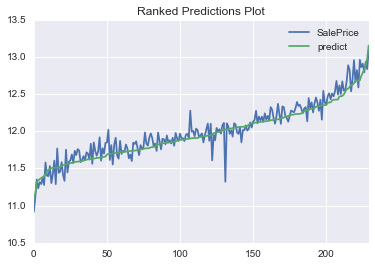

In [51]:
glm0_0 = glm_grid(encoded_combined_nums, 'SalePrice',  half_train, half_valid)
gen_submission_glm(glm0_0,test) # Valid RMSE: 0.1325 #0.1216

In [56]:
#glm0_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission_glm(glm0_1,test) # Valid RMSE: 0.11931 0.116

glm prediction progress: |████████████████████████████████████████████████| 100%


In [57]:
pred_blender('/Users/zhaorc/Desktop/ML/files', 
             ['Wed_Jun_28_18_20_10_2017.csv',
              'Wed_Jun_28_18_24_29_2017.csv'])
# 0.13337 on public leaderboard, better than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  111616.590094  102381.940726  106999.265410
1  1462  142175.020593  142154.134369  142164.577481
2  1463  173016.519084  167166.252038  170091.385561
3  1464  190380.120019  183069.989015  186725.054517
4  1465  211946.803098  202118.377125  207032.590112


In [61]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
#ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test,test) # 0.16494 on public leaderboard

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1498689887404_6


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.007853003651943
RMSE: 0.08861717470074862
MAE: 0.05100827498154921
RMSLE: 0.006893808013459485
Mean Residual Deviance: 0.007853003651943

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.016968616551748156
RMSE: 0.1302636424784297
MAE: 0.09777677240974243
RMSLE: 0.010149475940399387
Mean Residual Deviance: 0.016968616551748156

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.01737877027724037
RMSE: 0.13182856396563064
MAE: 0.08803862458342439
RMSLE: 0.010211667601823064
Mean Residual Deviance: 0.01737877027724037
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0880090,0.0005377,0.0870396,0.0888969,0.0880903
mean_residual_deviance,0.0173193,0.0017439,0.0184114,0.0196417,0.0139046
mse,0.0173193,0.0017439,0.0184114,0.0196417,0.0139046
r2,0.8880365,0.0024635,0.883395,0.8889255,0.8917889
residual_deviance,0.0173193,0.0017439,0.0184114,0.0196417,0.0139046
rmse,0.1312519,0.0067902,0.1356886,0.1401490,0.1179179
rmsle,0.0101616,0.0005652,0.0105334,0.0109000,0.0090512


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-28 19:28:53,7 min 36.977 sec,0.0,11.5392208,11.5324996,133.1536163,11.5129466,11.5056257,132.5479390
,2017-06-28 19:28:54,7 min 38.003 sec,1.0,11.4819725,11.4752177,131.8356917,11.4557013,11.4483439,131.2330931
,2017-06-28 19:28:54,7 min 38.026 sec,2.0,11.4251113,11.4183229,130.5331687,11.3988433,11.3914491,129.9336282
,2017-06-28 19:28:54,7 min 38.051 sec,3.0,11.3687604,11.3619384,129.2487136,11.3424955,11.3350646,128.6522036
,2017-06-28 19:28:54,7 min 38.076 sec,4.0,11.3123131,11.3054570,127.9684283,11.2860513,11.2785832,127.3749540
---,---,---,---,---,---,---,---,---,---
,2017-06-28 19:32:03,10 min 47.413 sec,3400.0,0.0905691,0.0525809,0.0082028,0.1294761,0.0968786,0.0167641
,2017-06-28 19:32:07,10 min 51.461 sec,3466.0,0.0899783,0.0522799,0.0080961,0.1306100,0.0982302,0.0170590
,2017-06-28 19:32:11,10 min 55.478 sec,3530.0,0.0895484,0.0516972,0.0080189,0.1297358,0.0973302,0.0168314
,2017-06-28 19:32:15,10 min 59.482 sec,3594.0,0.0890483,0.0513653,0.0079296,0.1303714,0.0979503,0.0169967



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
BsmtUnfSF|Id,105.0,1.0,0.0057673
Id|BsmtFinSF1,63.0,0.6,0.0034604
YrSold_Tencode|GarageYrBlt,56.0,0.5333333,0.0030759
BsmtUnfSF|BsmtFinSF1,56.0,0.5333333,0.0030759
GarageCars|Id,55.0,0.5238095,0.0030210
---,---,---,---
BsmtUnfSF|ScreenPorch,1.0,0.0095238,0.0000549
Foundation_Tencode|LotConfig_Tencode,1.0,0.0095238,0.0000549
BsmtFullBath|HalfBath,1.0,0.0095238,0.0000549
HouseStyle_Tencode|Heating_Tencode,1.0,0.0095238,0.0000549



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [59]:
gen_submission(h2o_xgb_preds1_test)

In [46]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
#ranked_preds_plot('SalePrice', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test,tesdt) # 0.14574 public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1498689887404_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.017465047624399446
RMSE: 0.13215539196112827
MAE: 0.08985047747144462
RMSLE: 0.010274034427532316
Mean Residual Deviance: 0.017465047624399446

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.016856437588690557
RMSE: 0.12983234415464645
MAE: 0.09266319949920339
RMSLE: 0.010043923523736568
Mean Residual Deviance: 0.016856437588690557

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.01857373183889105
RMSE: 0.13628547919309325
MAE: 0.08988988575395503
RMSLE: 0.01060257046671778
Mean Residual Deviance: 0.01857373183889105
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0898669,0.0003805,0.0892916,0.0905859,0.0897232
mean_residual_deviance,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
mse,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
r2,0.879554,0.0049428,0.8708518,0.8879668,0.8798433
residual_deviance,0.0185476,0.0015630,0.0203919,0.0198113,0.0154396
rmse,0.1359363,0.0058699,0.1428003,0.1407526,0.1242561
rmsle,0.0105669,0.0005157,0.0111116,0.0110530,0.0095361


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-28 18:54:03,4 min 4.625 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-28 18:54:03,4 min 5.087 sec,1.0,0.2053192,0.1442051,0.0421560,0.1914737,0.1385821,0.0366622
,2017-06-28 18:54:04,4 min 5.588 sec,2.0,0.2021184,0.1451268,0.0408518,0.1678469,0.1206358,0.0281726
,2017-06-28 18:54:04,4 min 6.077 sec,3.0,0.2059234,0.1444103,0.0424045,0.1531739,0.1111464,0.0234622
,2017-06-28 18:54:05,4 min 6.571 sec,4.0,0.1917852,0.1371583,0.0367816,0.1456185,0.1055259,0.0212048
---,---,---,---,---,---,---,---,---,---
,2017-06-28 18:55:33,5 min 35.108 sec,168.0,0.1324222,0.0899862,0.0175356,0.1298885,0.0927521,0.0168710
,2017-06-28 18:55:34,5 min 35.663 sec,169.0,0.1322458,0.0898968,0.0174889,0.1299202,0.0927988,0.0168793
,2017-06-28 18:55:34,5 min 36.217 sec,170.0,0.1322448,0.0898847,0.0174887,0.1297955,0.0927027,0.0168469
,2017-06-28 18:55:35,5 min 36.696 sec,171.0,0.1322186,0.0898393,0.0174818,0.1298279,0.0926693,0.0168553



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt_Tencode|GrLivArea,2081.1440430,1.0,0.0877169
Neighborhood_Tencode|OverallQual_Tencode,1428.1538086,0.6862350,0.0601944
BsmtQual_Tencode|GrLivArea,1332.3436279,0.6401977,0.0561561
Neighborhood_Tencode|GrLivArea,1069.4122314,0.5138579,0.0450740
LotShape_Tencode|OverallQual_Tencode,898.1904907,0.4315850,0.0378573
---,---,---,---
Street_Tencode|BsmtHalfBath,0.0,0.0,0.0
KitchenAbvGr|GarageCond_Tencode,0.0,0.0,0.0
BsmtHalfBath|WoodDeckSF,0.0,0.0,0.0
BsmtHalfBath|OverallQual_Tencode,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


NameError: name 'ranked_preds_plot' is not defined

In [51]:
# initialize extra trees model
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
#ranked_preds_plot('SalePrice', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.14855 public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1498689887404_2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.017323453985374403
RMSE: 0.13161859285592747
MAE: 0.08971813495800218
RMSLE: 0.010215616951008255
Mean Residual Deviance: 0.017323453985374403

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.01674616362065662
RMSE: 0.12940696898025478
MAE: 0.09253415775086733
RMSLE: 0.010005705432735396
Mean Residual Deviance: 0.01674616362065662

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.018302625034448353
RMSE: 0.13528719464327862
MAE: 0.089679622835509
RMSLE: 0.010531151070757647
Mean Residual Deviance: 0.018302625034448353
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0896436,0.0005868,0.0889772,0.0908133,0.0891402
mean_residual_deviance,0.0182710,0.0015450,0.0199324,0.0196966,0.0151841
mse,0.0182710,0.0015450,0.0199324,0.0196966,0.0151841
r2,0.8814029,0.0042932,0.8737618,0.8886153,0.8818315
residual_deviance,0.0182710,0.0015450,0.0199324,0.0196966,0.0151841
rmse,0.1349169,0.0058515,0.1411823,0.1403446,0.1232238
rmsle,0.0104935,0.0005173,0.0109919,0.0110294,0.0094591


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-28 19:01:37,4 min 44.728 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-28 19:01:37,4 min 45.252 sec,1.0,0.1884594,0.1315495,0.0355170,0.1964560,0.1408567,0.0385950
,2017-06-28 19:01:38,4 min 45.813 sec,2.0,0.1811277,0.1280890,0.0328072,0.1657293,0.1196089,0.0274662
,2017-06-28 19:01:38,4 min 46.302 sec,3.0,0.1842635,0.1298851,0.0339530,0.1537470,0.1102584,0.0236382
,2017-06-28 19:01:39,4 min 46.848 sec,4.0,0.1866581,0.1319614,0.0348412,0.1465753,0.1067205,0.0214843
---,---,---,---,---,---,---,---,---,---
,2017-06-28 19:03:18,6 min 26.028 sec,178.0,0.1314189,0.0896361,0.0172709,0.1296600,0.0927328,0.0168117
,2017-06-28 19:03:19,6 min 26.641 sec,179.0,0.1316618,0.0897088,0.0173348,0.1294732,0.0925901,0.0167633
,2017-06-28 19:03:19,6 min 27.204 sec,180.0,0.1315648,0.0897687,0.0173093,0.1294300,0.0925637,0.0167521
,2017-06-28 19:03:20,6 min 27.763 sec,181.0,0.1315993,0.0897156,0.0173184,0.1293843,0.0925078,0.0167403



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt_Tencode|GrLivArea,1915.9385986,1.0,0.0763218
Neighborhood_Tencode|OverallQual_Tencode,1629.6738281,0.8505877,0.0649184
Neighborhood_Tencode|GrLivArea,1325.6748047,0.6919193,0.0528085
BsmtQual_Tencode|GrLivArea,1322.3671875,0.6901929,0.0526767
LotShape_Tencode|OverallQual_Tencode,1045.6014404,0.5457385,0.0416517
---,---,---,---
3SsnPorch|OverallQual_Tencode,0.0,0.0,0.0
EnclosedPorch|BsmtHalfBath,0.0,0.0,0.0
Condition2_Tencode|BsmtHalfBath,0.0,0.0,0.0
BsmtHalfBath|OverallQual_Tencode,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


NameError: name 'ranked_preds_plot' is not defined

In [53]:
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test,test) 

drf prediction progress: |████████████████████████████████████████████████| 100%


In [52]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
#ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test,test) # 0.15062 public leaderboard

gbm Model Build progress: |██ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_86e4177fb430f7c8e717e18bfbe647c4> was cancelled by the user.

In [62]:
stack = H2OStackedEnsembleEstimator(training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[rf_model1, ert_model1, 
                                                h2o_xgb_model ])

stack.train(x=encoded_combined_nums,
            y='SalePrice',
            training_frame=train,
            validation_frame=valid)

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
#ranked_preds_plot('SalePrice', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission(stack_preds1_test,test)
# 0.14630 on public leaderboard


stackedensemble Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1498689887404_7
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.0034407737204677482
RMSE: 0.05865810873585806
MAE: 0.038323727129800055
RMSLE: 0.004567249541024737
R^2: 0.9778114573204629
Mean Residual Deviance: 0.0034407737204677482
Null degrees of freedom: 1000
Residual degrees of freedom: 998
Null deviance: 155.22490791465145
Residual deviance: 3.444214494188216
AIC: -2829.016029585025

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.015806196337453733
RMSE: 0.12572269619067886
MAE: 0.09338725977567938
RMSLE: 0.009779977163840879
R^2: 0.9062031545111939
Mean Residual Deviance: 0.015806196337453733
Null degrees of freedom: 458
Residual degrees of freedom: 456
Null deviance: 77.67997881888834
Residual

In [54]:
pwd

'/Users/zhaorc/Desktop/ML/files'

In [57]:
pred_blender('/Users/zhaorc/Desktop/ML/files',
            ['Wed_Jun_28_18_56_40_2017.csv',
             'Wed_Jun_28_19_08_51_2017.csv',
             
             ])

     Id     SalePrice0     SalePrice1           mean
0  1461  115618.585364  115372.946635  115495.766000
1  1462  145790.952075  144456.925647  145123.938861
2  1463  182612.710025  183921.055115  183266.882570
3  1464  187103.373944  188835.291566  187969.332755
4  1465  189100.822295  193122.915893  191111.869094
